<a href="https://colab.research.google.com/github/Bduz/intro_ml/blob/main/intro_rl/NB3_Temporal_Difference_Cliffworld/NB3_Temporal_Difference_Cliffworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 3: Temporal-Difference Learning

Welcome to the third notebook of the workshop! In this notebook, you will learn about the temporal-difference learning methods. You will use these methods in the Cliff Walking problem in [1]. Before we describe this problem, let's first briefly go over the temporal-difference (TD) methods, and see how they differ from the Monte Carlo (MC) methods.

One of the main drawbacks of MC is the fact that the agent has to wait until the end of an episode when it can obtain the actual return $G_t$ before it can update the state-value function estimate $V(S_t)$. On the one hand, MC has pretty solid convergence properties because it updates the value function estimate $V(S_t)$ toward the actual return $G_t$, which is an unbiased estimate of the true state-value function ${v_\pi }\left( {{S_t}} \right)$.
However, while the actual returns are pretty accurate estimates, they are also not very precise. Actual returns are also high-variance estimates of the true state-value function. It’s easy to see why: actual returns accumulate many random events in the same trajectory; all actions, all next states, all rewards are random events. So the actual return is unbiased, but has high variance.
And, due to the high variance of the actual returns, MC can be sample inefficient. All of that randomness becomes noise that can only be alleviated with many actual return samples.

What is TD's answer to this problem?

Let's first remember the equation for the value function:

$$
\begin{align}
    {v_\pi }\left( s \right) &\buildrel\textstyle.\over= \mathbb{E}\left[ {\left. {{G_t}} \right|{S_t} = s} \right] \tag{1} \\
    &=\mathbb{E}\left[ {\left. {{R_{t + 1}} + \gamma {G_{t + 1}}} \right|{S_t} = s} \right] \tag{2}  \\  
    &=\mathbb{E}\left[ {\left. {{R_{t + 1}} + \gamma {v_\pi }\left( {{S_{t + 1}}} \right)} \right|{S_t} = s} \right]  \tag{3}
\end{align}
$$

Let's also remember the Monte Carlo update for the value function:

$$
V\left( {{S_t}} \right) \leftarrow V\left( {{S_t}} \right) + \alpha \left[ {{G_t} - V\left( {{S_t}} \right)} \right]
$$

Instead of waiting until the end of an episode to observe the actual return, TD uses an estimate of it. The simples TD method makes the following update:

$$
V\left( {{S_t}} \right) \leftarrow V\left( {{S_t}} \right) + \alpha \left[ {{R_{t + 1}} + \gamma V\left( {{S_{t + 1}}} \right) - V\left( {{S_t}} \right)} \right]
$$

Roughly speaking, Monte Carlo methods use an estimate of Eq. (1) as a target, whereas TD methods use an estimate of Eq. (3) as a target. However, since ${{v_\pi }\left( {{S_{t + 1}}} \right)}$ is not known, TD uses the current estimate, ${V\left( {{S_{t + 1}}} \right)}$, instead. When the environment transitions from $S_t$ to $S_{t+1}$ and returns the reward $R_{t+1}$, the TD methods use $R_{t+1}$ and its current estimate of ${V\left( {{S_{t + 1}}} \right)}$ to make the above update. This effectively indicates that the target in the TD method is $R_{t+1} + {V\left( {{S_{t + 1}}} \right)}$, whereas the target is $G_t$ in the MC update. Since the TD method uses an existing estimate in its update, it is called a *bootstrapping* method. This TD method is called *TD(0)* or *one-step TD* as it is a special case of a wider class of TD algorithms (see Chapters 12 and 7 in [1]). The quantity
in the brackets in the TD(0) measures the estimated value of $S_t$ and the better estimate $R_{t+1} + {V\left( {{S_{t + 1}}} \right)}$. This quantity is called the *TD error*:
$$
{\delta _t} \buildrel\textstyle.\over= {R_{t + 1}} + \gamma V\left( {{S_{t + 1}}} \right) - V\left( {{S_t}} \right)
$$

The TD methods have low variance and some bias. The TD target includes the received reward from one transition and the current estimate of the value function. This causes much less variance compared to the MC target which depends on many actions, transitions and rewards. On the other hand, the TD methods have some bias, because they use in part the existing estimate to calculate a better estimate. This works out fine as the TD target includes the received reward $R_{t+1}$, which progressively feed reality into the estimates.

Pseudocode for TD(0) for prediction is given below.

<img src="https://github.com/Bduz/intro_ml/blob/main/intro_rl/NB3_Temporal_Difference_Cliffworld/images/td0_prediction.png?raw=1" width="500" height="300" align="left" />

In this notebook, you will use two TD algorithms (Sarsa and Q-Learning) in the *Cliff Walking* problem described on page 132 of [1]. In this environment shown in the figure below, the agent starts in the bottom left corner of the gridworld below and takes actions that move it in the four directions. Actions that would move the agent off of the cliff incur a reward of -100 and send the agent back to the start state. The reward for all other transitions is -1. An episode terminates when the agent reaches the bottom right corner. This is an undiscounted episodic task, and thus we set $\gamma$=1.

<img src="https://github.com/Bduz/intro_ml/blob/main/intro_rl/NB3_Temporal_Difference_Cliffworld/images/cliffworld.png?raw=1" width="500" height="300" align="left" />

### Section 0: Cloning the repo
Let's first clone the repository from github:

In [1]:
!git clone https://github.com/Bduz/intro_ml.git

Cloning into 'intro_ml'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 577 (delta 141), reused 131 (delta 56), pack-reused 290 (from 1)
Receiving objects: 100% (577/577), 53.11 MiB | 10.22 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (69/69), done.


In [2]:
import sys
sys.path.insert(0, '/content/intro_ml/intro_rl/NB3_Temporal_Difference_Cliffworld')

### Section 1: Import the necessary libraries
You begin by importing the necessary libraries.

In [3]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import agent
import cliffworld_env
from tqdm import tqdm

In [4]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

You will use the RL-Glue concept in this notebook just like in Notebook 1. The module *cliffworld_env* contains the code for the *Cliff Walking* problem which you will use in this notebook.

### Section 2: SARSA

Sarsa is a TD control algorithm that follows the pattern of generalized policy iteration (GPI) similar to Monte Carlo methods. To design the Sarsa algorithm (see Section 6.4 in [1]), first, we write the TD update rule for an action-value function rather than a state-value function:

$$
Q\left( {{S_t},{A_t}} \right) \leftarrow Q\left( {{S_t},{A_t}} \right) + \alpha \left[ {{R_{t + 1}} + \gamma Q\left( {{S_{t + 1}},{A_{t + 1}}} \right) - Q\left( {{S_t},{A_t}} \right)} \right]
$$

The reason for this is that if we learn the state-value function, we need the model of the MDP to do one-step
lookahead in order to see which action leads to the next state with the highest value. As we wish to do
model-free control, we use the action-value function in the TD update because the action value function
already includes the value of each action in a state.

The update rule above is carried out at each time step. If $S_{t+1}$ is terminal, then $Q(S_{t+1}, A_{t+1})$ is defined as zero.
Since this rule uses every element of a transition from one state to the next, $(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1})$, this
quintuple becomes the inspiration for the name of the algorithm, **Sarsa**. Pseudocode of the Sarsa control algorithm is given below. As can be seen in the pseudocode, we continually estimate $q_{\pi}$ for the behavior policy $\pi$, and at the same time change $\pi$ toward greediness with respect to $q_{\pi}$.

<img src="https://github.com/Bduz/intro_ml/blob/main/intro_rl/NB3_Temporal_Difference_Cliffworld/images/sarsa.png?raw=1" width="500" height="300" align="left" />

Below the Sarsa agent is coded. We advise you to pay attention to how the update is rule is written in *agent_step* and *agent_end* methods.

In [5]:
# SARSA agent here
class SarsaAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])

        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.


    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        # Perform an update
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount*self.q[state, action] - self.q[self.prev_state, self.prev_action])

        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

Before we introduce the Q-Learning agent in the next section, we would like to stress one more important aspect in RL. Reinforcement learning methods can be divided into two classes: *on-policy* and *off-policy*. On-policy learning is “learning on the job”, which means that the agent learns about the same policy it uses for generating experience. Off-policy learning, on the other hand, is “learning from others”, which means that the agent learns about a policy that’s different from the policy generating experiences. In on-policy learning, we learn from our own mistakes only. What if we want to learn from the mistakes of others? In on-policy learning, we can’t. In off-policy learning, there are two policies: a behavior policy, used to generate experiences, to interact with the environment, and a target policy, which is the policy we’re learning about. SARSA is an on-policy method; Q-learning is an off-policy one.

### Section 3: Q-Learning
Similar to Sarsa, Q-learning is a TD control algorithm following the pattern of GPI. In this section you will use a Q-Learning agent with $\epsilon$-greedy action selection (Section 6.5 in [1]). The update rule in Q-learning is the following:

$$
Q\left( {{S_t},{A_t}} \right) \leftarrow Q\left( {{S_t},{A_t}} \right) + \alpha \left[ {{R_{t + 1}} + \gamma \mathop {\max }\limits_a Q\left( {{S_{t + 1}},a} \right) - Q\left( {{S_t},{A_t}} \right)} \right]
$$

and the pseudocode for Q-learning is given below.

<img src="https://github.com/Bduz/intro_ml/blob/main/intro_rl/NB3_Temporal_Difference_Cliffworld/images/Q-learning.png?raw=1" width="500" height="300" align="left" />

The difference between the psedocodes of Sarsa and Q-learning is just one term in the TD target. However, this simple difference has important consequences. In the update rule of the Q-learning, we act greedily and take the maximum of ${Q\left( {{S_{t + 1}}, \cdot } \right)}$. This indicates that the learned action-value function directly approximates the optimal action-value function, and the target policy is greedy with respect to $Q(s, a)$. How does Q-learning explore then? Q-learning uses a different policy for exploration (called behavior policy); e.g., epsilon-greedy policy with respect to $Q(s, a)$. This means that we follow the behavior policy in state $S_t$, and observe the next state $S_{t+1}$ and reward $R_{t+1}$. However, when deciding which action to take in state $S_{t+1}$, we follow the target policy and act greedily. Since the behavior and target policies are different than each other, Q-learning becomes an off-policy algorithm.

Below the Q-learning agent is coded. We advise you to pay attention to how the update is rule is written in *agent_step* method, and compare it to Sarsa's method.

In [6]:
# Q-Learning agent here
class QLearningAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])

        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.


    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        # Perform an update
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount*np.max(current_q) - self.q[self.prev_state, self.prev_action])

        self.prev_state = state
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Section 4:  Solving the Cliff Walking problem
Using the experiment program in the cell below we now compare the Sarsa and Q-learning agents on the Cliff World environment described above, and plot the sum of rewards during each episode for the two agents.

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


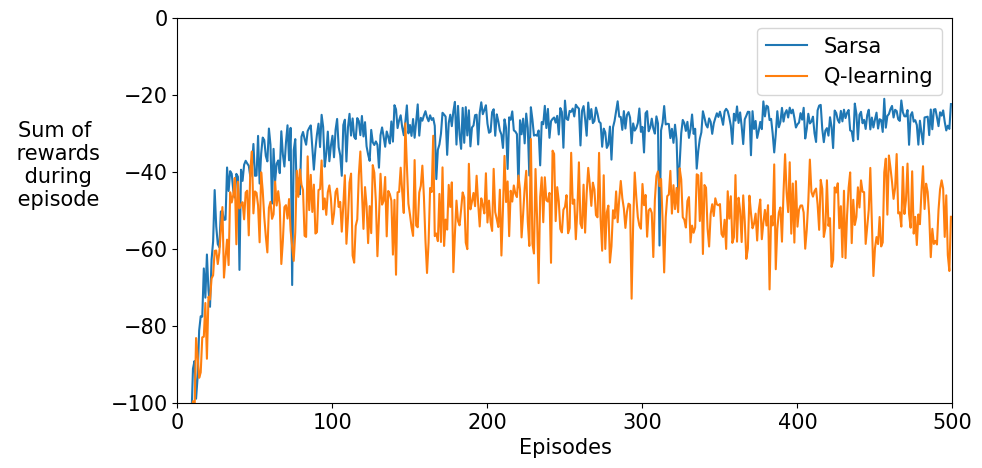

In [7]:
agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent
}
env = cliffworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 500 # The number of episodes in each run

for algorithm in ["Sarsa", "Q-learning"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0)
            else:
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1

            reward_sums.append(rl_glue.rl_return())

        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

for algorithm in ["Sarsa", "Q-learning"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,500)
plt.ylim(-100,0)
plt.legend()
plt.show()

To see why these two agents behave differently, let's inspect the states they visit most. Run the cell below to generate plots showing the number of timesteps that the agents spent in each state over the last 10 episodes.

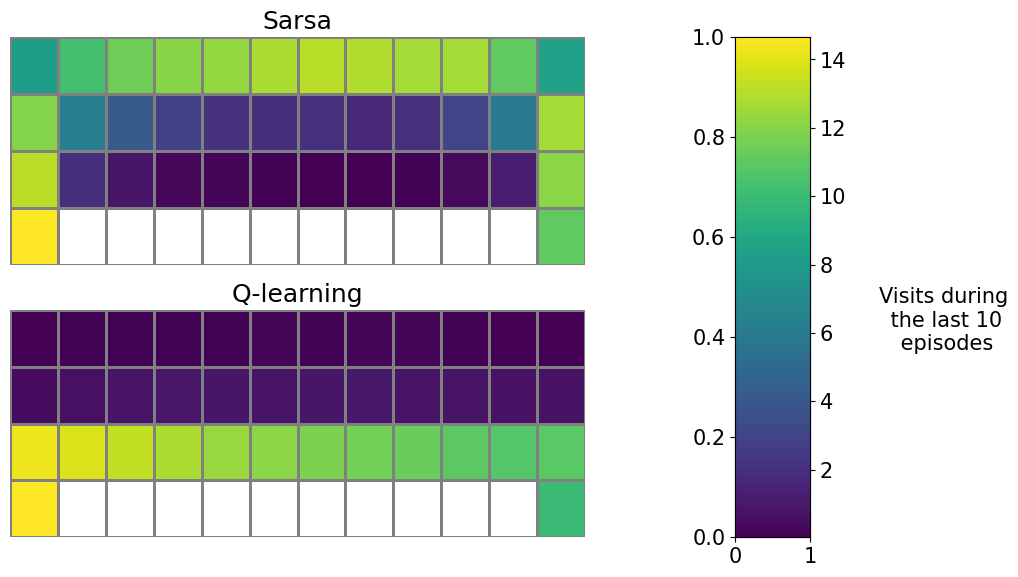

In [8]:
for algorithm, position in [("Sarsa", 211), ("Q-learning", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

The Q-learning agent learns the optimal policy, one that moves along the cliff and reaches the goal in as few steps as possible. However, since the agent does not follow the optimal policy and uses $\epsilon$-greedy exploration, it occasionally falls off the cliff. Sarsa, on the other hand, takes the action selection into account and learns the longer but safer path through the upper part of the grid. Although Q-learning actually learns the values of the optimal policy, its online performance is worse than that of Sarsa, which learns the roundabout policy. Of course, if $\epsilon$ were gradually reduced, then both methods would asymptotically converge to the optimal policy.

Previously we used a fixed step-size of 0.5 for the agents. What happens with other step-sizes? Does this difference in performance persist?

In the next experiment we will try 10 different step-sizes from 0.1 to 1.0 and compare the sum of rewards per episode averaged over the first 100 episodes (similar to the interim performance curves in Figure 6.3 in [1]). Shaded regions show standard errors. The cell below might take up to 10 minutes to run.

100%|██████████| 100/100 [00:11<00:00,  8.46it/s]


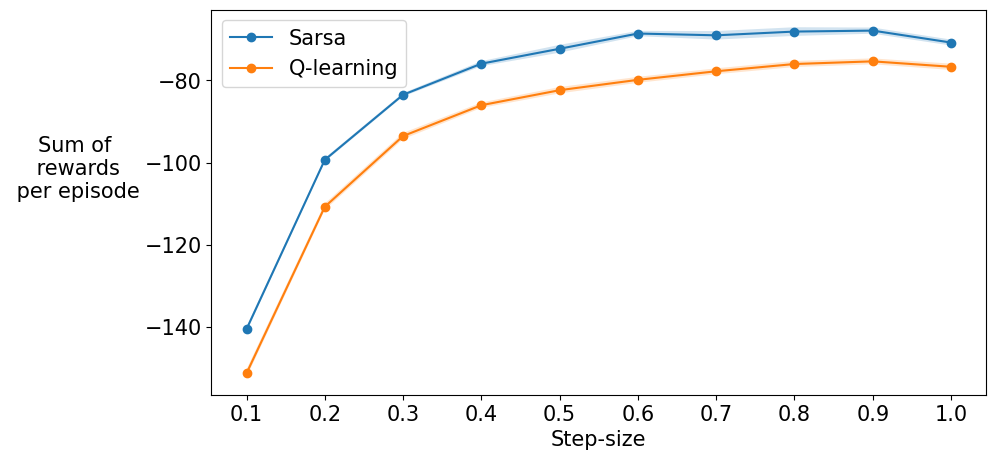

In [9]:
agents = {
    "Sarsa": SarsaAgent,
    "Q-learning": QLearningAgent
}
env = cliffworld_env.Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 100
num_episodes = 100
all_reward_sums = {}

for algorithm in ["Sarsa", "Q-learning"]:
    for step_size in step_sizes:
        all_reward_sums[(algorithm, step_size)] = []
        agent_info["step_size"] = step_size
        for run in tqdm(range(num_runs)):
            agent_info["seed"] = run
            rl_glue = RLGlue(env, agents[algorithm])
            rl_glue.rl_init(agent_info, env_info)

            return_sum = 0
            for episode in range(num_episodes):
                rl_glue.rl_episode(0)
                return_sum += rl_glue.rl_return()
            all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)


for algorithm in ["Sarsa", "Q-learning"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

Sarsa shows an advantage over Q-learning in this problem across a wide range of step-sizes.

### Section 5: Conclusions

Congratulations, you finished the third notebook in the RL workshop! You have:

- learned about Temporal-Difference learning, and how it differs than Monte Carlo methods
- learned Sarsa with $\epsilon$-greedy action selection
- learned Q-Learning with $\epsilon$-greedy action selection
- investigated the behavior of these two algorithms on Cliff World

In summary, TD differs from MC in the following fashions:

<img src="https://github.com/Bduz/intro_ml/blob/main/intro_rl/NB3_Temporal_Difference_Cliffworld/images/MC_versus_TD.png?raw=1" width="700" height="500" align="left" />

### Section 6: Challenges
- Can you implement an Expected Sarsa agent with $\epsilon$-greedy action selection (Section 6.6 in [1]), and compare its performance to Sarsa and Q-Learning agents in the exercises in Section 4?
- An important issue arises in algorithms like Q-learning called *maximisation bias*. We recommend you to read about this issue in Section 6.7 in [1]. Can you implement a Double Q-learning agent, and solve Example 6.7?

## References
[1] R. S. Sutton and A. G. Barto, "Reinforcement Learning", MIT Press, 2018.